In [1]:
import numpy as np
from imutils import paths
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
training_dir = os.path.join(os.getcwd(), 'train'  )
testing_dir = os.path.join(os.getcwd(), 'test' )

In [3]:
def train_val_generator(training, validation):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(
        directory=training,
        batch_size=64,
        class_mode='categorical',
        target_size=(150,150)
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        directory=validation,
        batch_size=64,
        class_mode='categorical',
        target_size=(150,150)
    )

    return train_generator, validation_generator

In [4]:
train_generator, validation_generator = train_val_generator(training_dir, testing_dir)

Found 2139 images belonging to 15 classes.
Found 542 images belonging to 15 classes.


# LOAD TRANSFER LEARNING

In [5]:
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
base_model = InceptionV3(input_shape = (150, 150, 3),
        include_top = False,
        weights=os.path.join(os.getcwd(), 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'))

In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)


x = tf.keras.layers.Dense(15, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
optimizers = Adam(learning_rate= 0.0001)
model.compile(optimizer= optimizers,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

In [11]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 30
                    
                    )

Epoch 1/30
34/34 [==============================] - 44s 851ms/step - loss: 2.7201 - accuracy: 0.2183 - val_loss: 1.8832 - val_accuracy: 0.4041
Epoch 2/30
34/34 [==============================] - 25s 732ms/step - loss: 1.8869 - accuracy: 0.4072 - val_loss: 1.4838 - val_accuracy: 0.5314
Epoch 3/30
34/34 [==============================] - 25s 740ms/step - loss: 1.6043 - accuracy: 0.5054 - val_loss: 1.1773 - val_accuracy: 0.6513
Epoch 4/30
34/34 [==============================] - 25s 749ms/step - loss: 1.4090 - accuracy: 0.5676 - val_loss: 1.0651 - val_accuracy: 0.6790
Epoch 5/30
34/34 [==============================] - 25s 739ms/step - loss: 1.2895 - accuracy: 0.5965 - val_loss: 0.9783 - val_accuracy: 0.7177
Epoch 6/30
34/34 [==============================] - 25s 727ms/step - loss: 1.2348 - accuracy: 0.6124 - val_loss: 0.9425 - val_accuracy: 0.7362
Epoch 7/30
34/34 [==============================] - 25s 734ms/step - loss: 1.1036 - accuracy: 0.6583 - val_loss: 0.9077 - val_accuracy: 0.7196

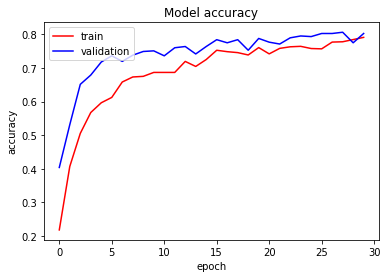

In [28]:
plt.plot(history.history['accuracy'], label='train', color="red")
plt.plot(history.history['val_accuracy'], label='validation', color="blue")
plt.title('Model accuracy')
plt.legend(loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('accmodelv3.png')
plt.show()

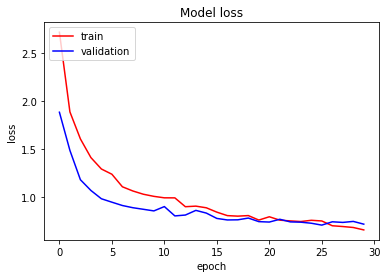

In [29]:
plt.plot(history.history['loss'], label='train', color="red")
plt.plot(history.history['val_loss'], label='validation', color="blue")
plt.title('Model loss')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('lossmodelv3.png')
plt.show()

In [14]:
#saving model
model.save('modelv3.h5')

# TESTING IMAGE

In [15]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

In [16]:
#LOAD MODEL
model = os.path.join('modelv3.h5')
model = tf.keras.models.load_model(model)

In [17]:
path = os.getcwd()
labels = []
dataset_path = os.path.join(path, 'dataset')
dataset_path = os.path.join(path, 'dataset')
imagePaths = paths.list_images(dataset_path)

for imagepath in imagePaths:
  label = imagepath.split(os.path.sep)[-2]
  labels.append(label)

labels_train_unique = np.unique(np.array(labels))

food = {}

for i in range(len(labels_train_unique)):
  food[labels_train_unique[i]] = i
food

{'Gulai_ayam': 0,
 'Kerak_telor': 1,
 'Soto_Ayam': 2,
 'bika_ambon': 3,
 'gudeg': 4,
 'klepon': 5,
 'martabak': 6,
 'nasi_tumpeng': 7,
 'pecel': 8,
 'pempek': 9,
 'rawon': 10,
 'rendang': 11,
 'sate': 12,
 'serabi': 13,
 'tahu_gejrot': 14}

d:\anaconda\envs\tfod\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


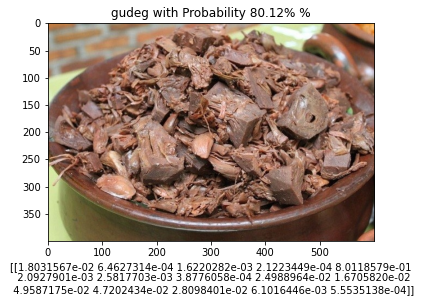

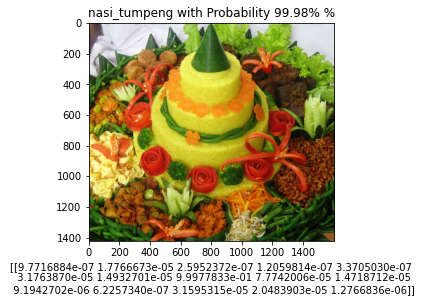

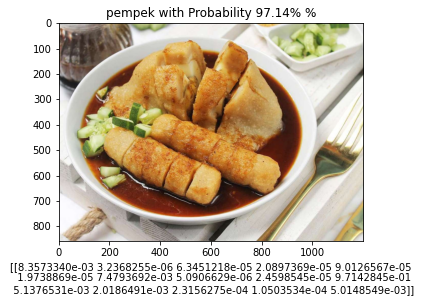

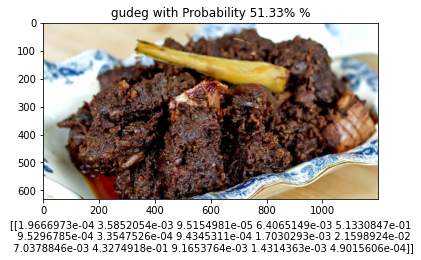

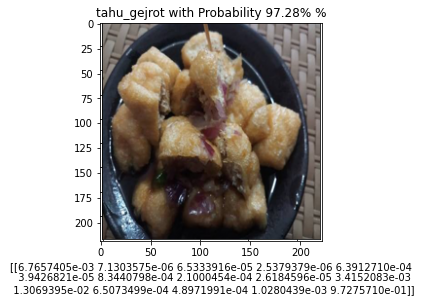

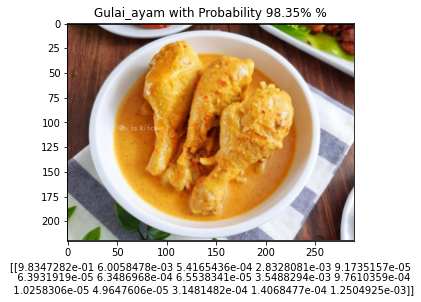

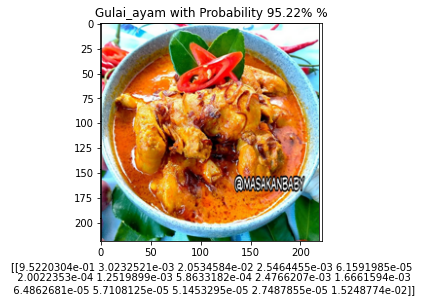

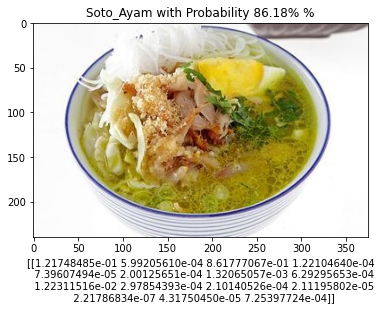

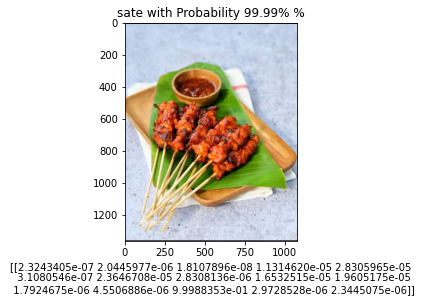

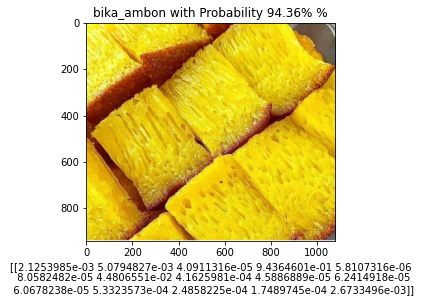

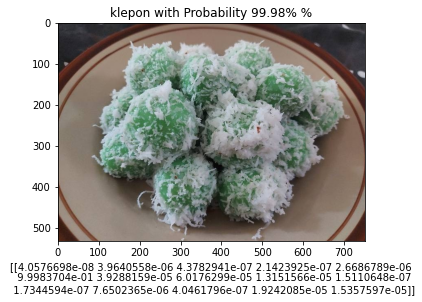

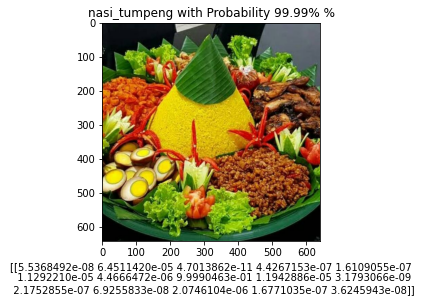

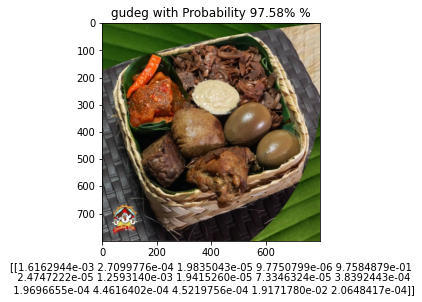

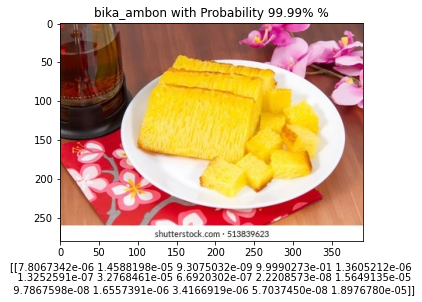

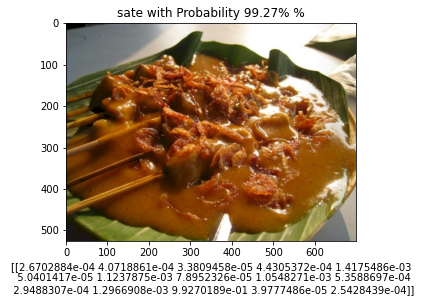

In [19]:
image_path = os.path.join(os.getcwd(), 'test_image')

for a in os.listdir (image_path):
    images = os.path.join(image_path, a)
    images = image.load_img(images, target_size=(150, 150))
    img = image.img_to_array(images)
    img = np.expand_dims(img, axis=0)
    processed_image = np.array(img, dtype='float') / 225.0
    pred = model.predict(processed_image)
 

    i = 0
    i_max=0
    max_val = ""

    for (k, result) in enumerate(food.keys()):

        if (pred[i][k] > i_max):
            i_max = pred[i][k]
            max_val = result

        txt = str(max_val) + " with Probability "+ str("{:.4}%".format(i_max*100)) + " %"

    gambar = mpimg.imread(os.path.join(image_path, a))
    plt.figure()
    plt.imshow(gambar)
    plt.title(txt)
    plt.xlabel(pred)

# CONVERT TO TFLITE

In [20]:
import os
import tensorflow as tf
import tensorflow_hub as hub

In [21]:
model_path = tf.keras.models.load_model(os.path.join(os.getcwd(), 'modelv3.h5'))

converter = tf.lite.TFLiteConverter.from_keras_model(model_path)
tflite_model = converter.convert()

open('modelv3.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\angga\AppData\Local\Temp\tmpry1j_8qa\assets


96568392

# TESTING TFLITE

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [23]:
path = os.getcwd()
labels = []
dataset_path = os.path.join(path, 'dataset')
dataset_path = os.path.join(path, 'dataset')
imagePaths = paths.list_images(dataset_path)

for imagepath in imagePaths:
  label = imagepath.split(os.path.sep)[-2]
  labels.append(label)

labels_train_unique = np.unique(np.array(labels))

food = {}

for i in range(len(labels_train_unique)):
  food[labels_train_unique[i]] = i
food

{'Gulai_ayam': 0,
 'Kerak_telor': 1,
 'Soto_Ayam': 2,
 'bika_ambon': 3,
 'gudeg': 4,
 'klepon': 5,
 'martabak': 6,
 'nasi_tumpeng': 7,
 'pecel': 8,
 'pempek': 9,
 'rawon': 10,
 'rendang': 11,
 'sate': 12,
 'serabi': 13,
 'tahu_gejrot': 14}

d:\anaconda\envs\tfod\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


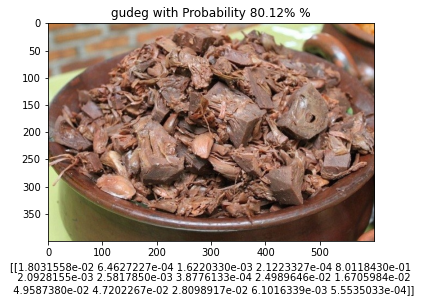

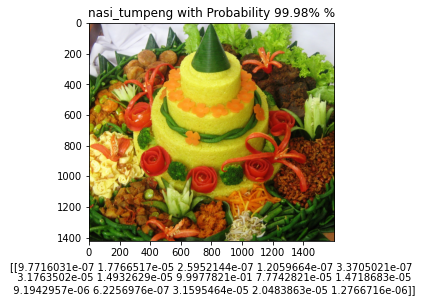

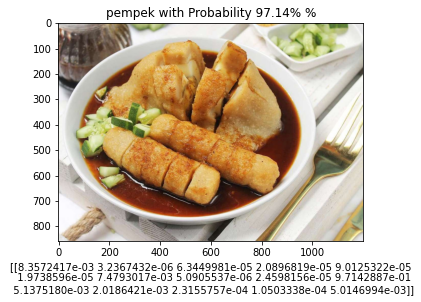

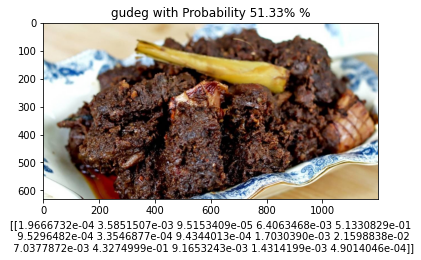

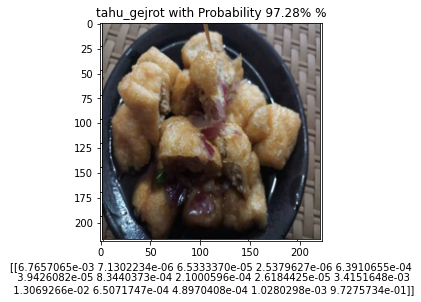

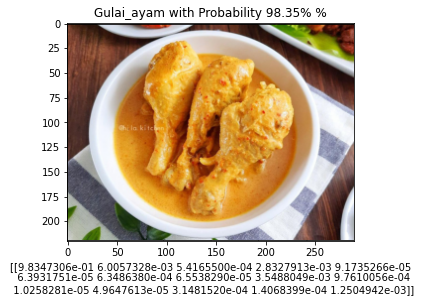

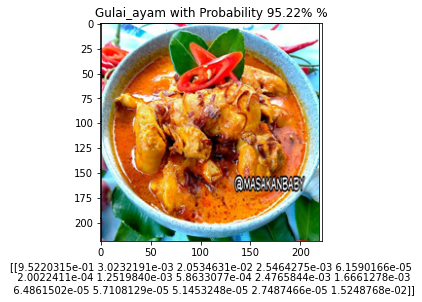

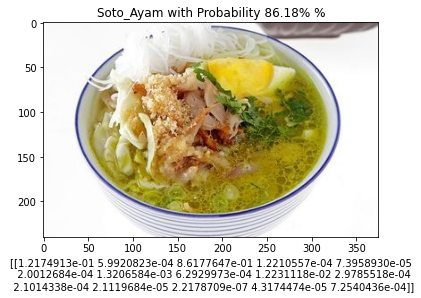

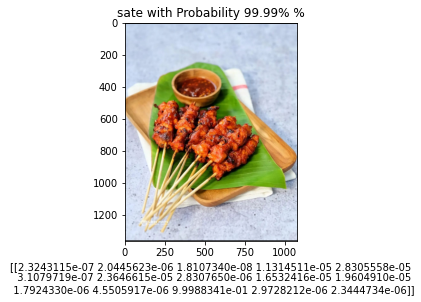

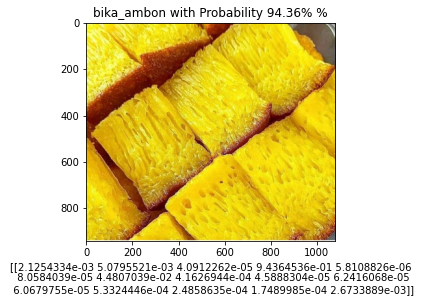

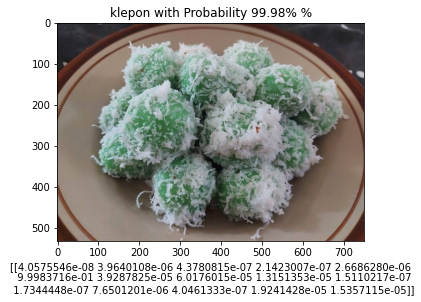

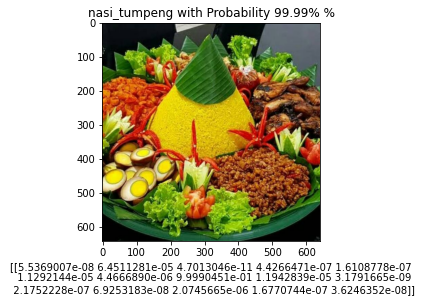

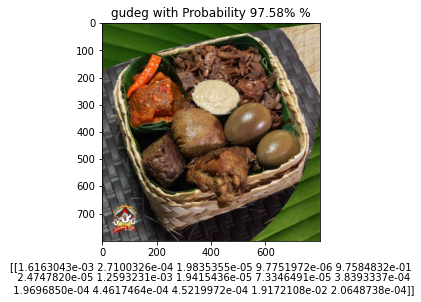

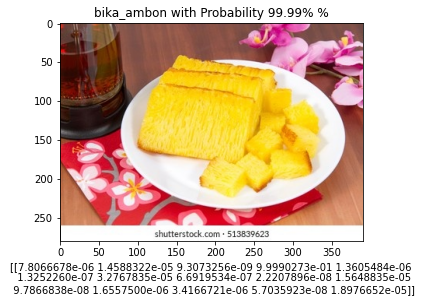

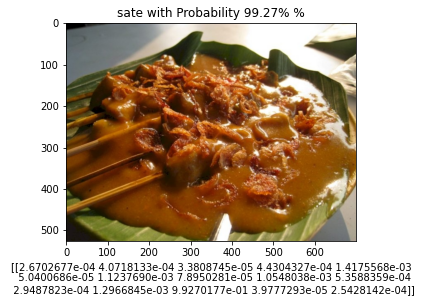

In [24]:
image_path = os.path.join(os.getcwd(), 'test_image')

for a in os.listdir (image_path):
    images = os.path.join(image_path, a)
    images = image.load_img(images, target_size=(150, 150))
    img = image.img_to_array(images)
    img = np.expand_dims(img, axis=0)
    processed_image = np.array(img, dtype='float32') / 225.0

    #load tflite
    interpreter = tf.lite.Interpreter(model_path='modelv3.tflite')
    interpreter.allocate_tensors()

    #input tensor
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    #test the model
    input_shape = input_details[0]['shape']
    
    interpreter.set_tensor(input_details[0]['index'], processed_image)

    interpreter.invoke()

    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    #print(output_data)

    i = 0
    i_max=-1
    max_val = ""

    for (k, result) in enumerate(food.keys()):

        if (output_data[i][k] > i_max):
            i_max = output_data[i][k]
            max_val = result

        txt = str(max_val) + " with Probability "+ str("{:.4}%".format(i_max*100)) + " %"
    
    #print(txt)
    gambar = mpimg.imread(os.path.join(image_path, a))
    plt.figure()
    plt.imshow(gambar)
    plt.title(txt)
    plt.xlabel(output_data)


In [30]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="modelv3.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 150 150   3] <class 'numpy.float32'>

1 output(s):
[ 1 15] <class 'numpy.float32'>
